In [ ]:
!pip install transformers
!pip install emoji
!pip install geopandas
!pip install opencage
!pip install googlemaps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=d29e4a3b04d8f1513ceaf2fca533d1a57cc8f9c9cba11b68cf78183a2c384e20
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7

In [ ]:
import requests
import tweepy
import time
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import emoji
import nltk
import torch
from torch.nn.functional import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
API_KEY = 'not_shown'
API_SECRET_KEY = 'not_shown'
ACCESS_TOKEN = 'not_shown'
ACCESS_SECRET_TOKEN = 'not_shown'

In [ ]:
auth = tweepy.OAuthHandler(API_KEY, API_SECRET_KEY)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET_TOKEN)

api = tweepy.API(auth)

def fetch_tweets(query, since, until, max_count):
    tweets = []
    max_id = None
    end_date = datetime.strptime(until, '%Y-%m-%d').date()

    while len(tweets) < max_count:
        fetched_tweets = api.search_tweets(q=query, count=100, lang='en', tweet_mode='extended', max_id=max_id)

        if not fetched_tweets:
            break

        for tweet in fetched_tweets:
            tweet_date = tweet.created_at.date()
            full_text = tweet.full_text
            word_count = len(full_text.split())

            if tweet_date >= datetime.strptime(since, '%Y-%m-%d').date() and tweet_date <= end_date and word_count <= 100:
                tweets.append(tweet._json)

                if len(tweets) >= max_count:
                    break

            max_id = tweet.id - 1

    return tweets

query = "#chatgpt -filter:retweets"
since = "2022-11-30"
until = "2023-04-13"
count = 10000

tweets = fetch_tweets(query, since, until, count)
with open('tweets_10k.json', 'w') as outfile:
    json.dump(tweets, outfile)

print(f"Fetched {len(tweets)} tweets about {query} from {since} to {until}")

In [ ]:
len(tweets)

10000

In [ ]:
# load tweets

tweets = json.load(open("/content/tweets_10k.json"))

In [ ]:
# save to df
full_text = [i['full_text'] for i in tweets]
created_at = [i['created_at'] for i in tweets]
name = [i['user']['name'] for i in tweets]
screen_name = [i['user']['screen_name'] for i in tweets]
location = [i['user']['location'] for i in tweets]
description = [i['user']['description'] for i in tweets]
followers_count = [i['user']['followers_count'] for i in tweets]
friends_count = [i['user']['friends_count'] for i in tweets]
listed_count = [i['user']['listed_count'] for i in tweets]
favourites_count = [i['user']['favourites_count'] for i in tweets]
statuses_count = [i['user']['statuses_count'] for i in tweets]
retweet_count = [i['retweet_count'] for i in tweets]
favorite_count = [i['favorite_count'] for i in tweets]

data_dict = {
    'FullText': full_text,
    'CreatedAt': created_at,
    'Name': name,
    'ScreenName': screen_name,
    'Location': location,
    'Description': description,
    'FollowersCount': followers_count,
    'FriendsCount': friends_count,
    'ListedCount': listed_count,
    'FavouritesCount': favourites_count,
    'StatusesCount': statuses_count,
    'RetweetCount': retweet_count,
    'FavoriteCount': favorite_count,
}

tweet_df = pd.DataFrame(data_dict)

In [ ]:
tweet_df.head()

,FullText,CreatedAt,Name,ScreenName,Location,Description,FollowersCount,FriendsCount,ListedCount,FavouritesCount,StatusesCount,RetweetCount,FavoriteCount
0,@stone_toss $Arcai Human Validation for #Ai #1...,Thu Apr 13 23:59:11 +0000 2023,Pipe,cryptopipe82,South Jersey,$ARCAI $LINK $Pi #Unvaccinated,509,1330,6,17598,11574,0,0
1,More: https://t.co/SZYfP9WESZ\n\n#GDPR #EDPB #...,Thu Apr 13 23:59:09 +0000 2023,Fabrizio Degni,fabrizio_degni,here but also there,Tech Evangelist.,509,178,4,4141,5984,1,1
2,This year we are sponsoring the AI &amp; Autom...,Thu Apr 13 23:58:59 +0000 2023,QMetrix,QMetrixHQ,"Melbourne, Australia",QMetrix provides professional advisory service...,22,12,1,0,526,1,1
3,#ChatGPT thought this was funny. Is that a red...,Thu Apr 13 23:58:48 +0000 2023,VanEck,vaneck_us,New York City,"Founded in ‘55, we offer passive + active inve...",12838,479,194,110,3991,1,1
4,Do you remember what's happened to #ChatGPT an...,Thu Apr 13 23:57:30 +0000 2023,Fabrizio Degni,fabrizio_degni,here but also there,Tech Evangelist.,509,178,4,4141,5984,1,0


### Clean fetched tweet

In [ ]:
# Clean emojis from text
def strip_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

# Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

# Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
tweet_df['FullTextCleaned'] = tweet_df['FullText'].apply(strip_emoji)
tweet_df['FullTextCleaned'] = tweet_df['FullTextCleaned'].apply(strip_all_entities)
tweet_df['FullTextCleaned'] = tweet_df['FullTextCleaned'].apply(clean_hashtags)
tweet_df['FullTextCleaned'] = tweet_df['FullTextCleaned'].apply(filter_chars)
tweet_df['FullTextCleaned'] = tweet_df['FullTextCleaned'].apply(remove_mult_spaces)
tweet_df.head()

,FullText,CreatedAt,Name,ScreenName,Location,Description,FollowersCount,FriendsCount,ListedCount,FavouritesCount,StatusesCount,RetweetCount,FavoriteCount,FullTextCleaned
0,@stone_toss $Arcai Human Validation for #Ai #1...,Thu Apr 13 23:59:11 +0000 2023,Pipe,cryptopipe82,South Jersey,$ARCAI $LINK $Pi #Unvaccinated,509,1330,6,17598,11574,0,0,arcai human validation for ai 1000xgem chatgpt
1,More: https://t.co/SZYfP9WESZ\n\n#GDPR #EDPB #...,Thu Apr 13 23:59:09 +0000 2023,Fabrizio Degni,fabrizio_degni,here but also there,Tech Evangelist.,509,178,4,4141,5984,1,1,more gdpr edpb chatgpt openai
2,This year we are sponsoring the AI &amp; Autom...,Thu Apr 13 23:58:59 +0000 2023,QMetrix,QMetrixHQ,"Melbourne, Australia",QMetrix provides professional advisory service...,22,12,1,0,526,1,1,this year we are sponsoring the ai amp automat...
3,#ChatGPT thought this was funny. Is that a red...,Thu Apr 13 23:58:48 +0000 2023,VanEck,vaneck_us,New York City,"Founded in ‘55, we offer passive + active inve...",12838,479,194,110,3991,1,1,chatgpt thought this was funny is that a red flag
4,Do you remember what's happened to #ChatGPT an...,Thu Apr 13 23:57:30 +0000 2023,Fabrizio Degni,fabrizio_degni,here but also there,Tech Evangelist.,509,178,4,4141,5984,1,0,do you remember whats happened to chatgpt and ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/sentiment_transfer_learning_transformer")

# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/sentiment_transfer_learning_transformer/')

In [ ]:
def analyze_sent(input_sentence):
    input_tokens = tokenizer(input_sentence, return_tensors="pt")

    # Move the input tensor to the same device as the model (either 'cpu' or 'cuda')
    input_tokens = {key: val.to(loaded_model.device) for key, val in input_tokens.items()}

    # Pass the tokenized input through the model
    with torch.no_grad():
        model_output = loaded_model(**input_tokens)

    # Extract logits from the model output
    logits = model_output.logits

    # Convert logits to probabilities using the softmax function
    probabilities = softmax(logits, dim=1)

    # Get the predicted class (the index with the highest probability)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class, probabilities

In [ ]:
analyze_sent("The thunderous storm left a trail of destruction, with homes torn apart and lives upended.")[1].tolist()[0]

[0.7231878042221069,
 0.25978559255599976,
 0.01124203484505415,
 0.004521059803664684,
 0.0012634764425456524]

### Predict sentiment and propability for each classes

In [ ]:
tweet_df['Sentiment'] = tweet_df['FullTextCleaned'].apply(lambda x: analyze_sent(x)[0])
tweet_df['SentProbe'] = tweet_df['FullTextCleaned'].apply(lambda x: analyze_sent(x)[1].tolist()[0])

In [ ]:
def convert_dt(timestamp):
    dt = datetime.strptime(timestamp, "%a %b %d %H:%M:%S %z %Y")
    formatted_dt = dt.strftime("%Y-%m-%d %H:%M:%S")
    return formatted_dt

In [ ]:
tweet_df['CreatedAt'] = tweet_df['CreatedAt'].apply(convert_dt)

In [ ]:
def convert_sent(sent):
    if sent == 0:
        label = "Extremely Negative"
    elif sent == 1:
        label = "Negative"
    elif sent == 2:
        label = "Neutral"
    elif sent == 3:
        label = "Positive"
    elif sent == 4:
        label = "Extremely Positive"
    return label

In [ ]:
tweet_df['SentLabel'] = tweet_df['Sentiment'].apply(convert_sent)

In [ ]:
tweet_df.head()

,FullText,CreatedAt,Name,ScreenName,Location,Description,FollowersCount,FriendsCount,ListedCount,FavouritesCount,StatusesCount,RetweetCount,FavoriteCount,FullTextCleaned,Sentiment,SentProbe,SentLabel
0,@stone_toss $Arcai Human Validation for #Ai #1...,2023-04-13 23:59:11,Pipe,cryptopipe82,South Jersey,$ARCAI $LINK $Pi #Unvaccinated,509,1330,6,17598,11574,0,0,arcai human validation for ai 1000xgem chatgpt,2,"[0.0007180683896876872, 0.008629546500742435, ...",Neutral
1,More: https://t.co/SZYfP9WESZ\n\n#GDPR #EDPB #...,2023-04-13 23:59:09,Fabrizio Degni,fabrizio_degni,here but also there,Tech Evangelist.,509,178,4,4141,5984,1,1,more gdpr edpb chatgpt openai,2,"[0.0008805192192085087, 0.01184498704969883, 0...",Neutral
2,This year we are sponsoring the AI &amp; Autom...,2023-04-13 23:58:59,QMetrix,QMetrixHQ,"Melbourne, Australia",QMetrix provides professional advisory service...,22,12,1,0,526,1,1,this year we are sponsoring the ai amp automat...,4,"[0.001489132409915328, 0.0009516692371107638, ...",Extremely Positive
3,#ChatGPT thought this was funny. Is that a red...,2023-04-13 23:58:48,VanEck,vaneck_us,New York City,"Founded in ‘55, we offer passive + active inve...",12838,479,194,110,3991,1,1,chatgpt thought this was funny is that a red flag,3,"[0.0010652055498212576, 0.00780403520911932, 0...",Positive
4,Do you remember what's happened to #ChatGPT an...,2023-04-13 23:57:30,Fabrizio Degni,fabrizio_degni,here but also there,Tech Evangelist.,509,178,4,4141,5984,1,0,do you remember whats happened to chatgpt and ...,3,"[0.0009723476250655949, 0.00240786443464458, 0...",Positive


In [ ]:
tweet_df.to_csv("tweets_info_10k.csv")

### keep unique user

In [ ]:
tweet_df = pd.read_csv("tweets_info_10k.csv")
tweet_df.shape

(10000, 18)

In [ ]:
tweet_no_dup_df = tweet_df.drop_duplicates(['ScreenName'])

### Overall sentiment

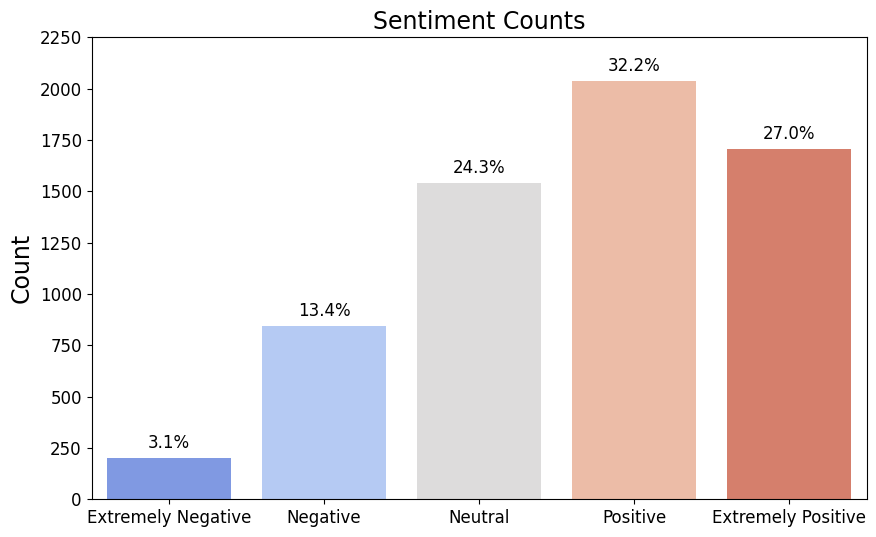

In [ ]:
sent_counts = tweet_no_dup_df['SentLabel'].value_counts().reindex(['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])

colors = sns.color_palette("coolwarm", n_colors=5)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sent_counts.index, y=sent_counts, palette=colors)

percentages = sent_counts / sent_counts.sum() * 100
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 50,
            '{:1.1f}%'.format(percentages[i]), ha="center", fontsize=12)

plt.xlabel('')
plt.ylabel('Count', fontsize = 17)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 2250)
plt.title('Sentiment Counts', fontsize = 17)
plt.savefig("sentiment_count.pdf", bbox_inches = 'tight')
plt.show()

### Geographical analysis

In [ ]:
import googlemaps

API_KEY = "not_shown"

gmaps = googlemaps.Client(key=API_KEY, requests_kwargs={"headers": {"User-Agent": "my_geocoding_app"}})

# convert location to latitude and longitude
def geocode_location(location):
    if not location:
        return None
    try:
        result = gmaps.geocode(location)
        if result:
            return result[0]["geometry"]["location"]
        else:
            return None
    except Exception as e:
        print(f"Error while geocoding '{location}': {e}")
        return None

tweet_df['Coordinates'] = tweet_df['Location'].apply(lambda x: geocode_location(x))

tweet_df = tweet_df.dropna(subset=['Coordinates'])
tweet_df['Latitude'] = tweet_df['Coordinates'].apply(lambda x: x['lat'])
tweet_df['Longitude'] = tweet_df['Coordinates'].apply(lambda x: x['lng'])

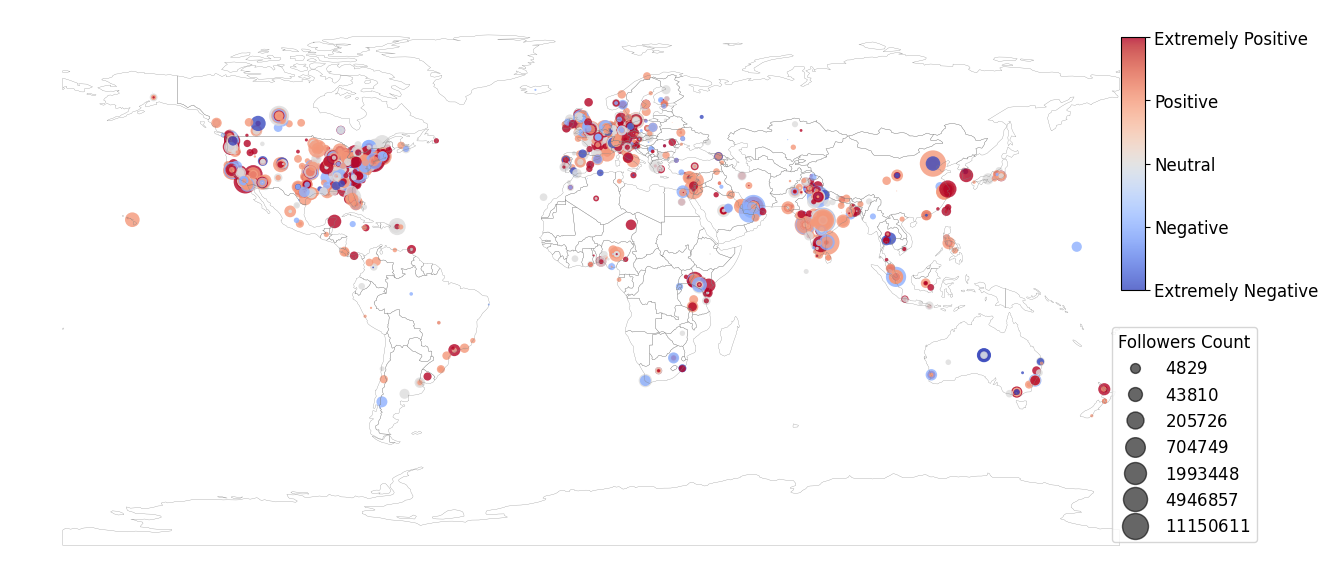

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a color map for gradient color
sentiment_colors = {'Extremely Negative': 0, 'Negative': 0.25, 'Neutral': 0.5, 'Positive': 0.75, 'Extremely Positive': 1}
tweet_df['SentimentColor'] = tweet_df['SentLabel'].map(sentiment_colors)

fig, ax = plt.subplots(figsize=(15, 10))

# Plot world map
world.boundary.plot(ax=ax, linewidth=0.2, color='gray')

# Plot dots on the map
sc = ax.scatter(tweet_df['Longitude'], tweet_df['Latitude'], c=tweet_df['SentimentColor'], cmap='coolwarm', 
                s=np.log10(tweet_df['FollowersCount'] + 1) ** 3, alpha=0.8, edgecolors='none')

cax = inset_axes(ax, width='2%', height='45%', loc='upper right', borderpad=2)
cbar = plt.colorbar(sc, cax=cax, orientation='vertical', shrink=0.3)
cbar.set_ticks(list(sentiment_colors.values()))
cbar.set_ticklabels(list(sentiment_colors.keys()))
cbar.ax.tick_params(labelsize=12)

handles, labels = sc.legend_elements(prop="sizes", alpha=0.6)
labels = ['$\\mathdefault{' + str(int(10 ** (int(i.split("{")[1].split("}")[0]) ** (1/3)) - 1)) + "}$" for i in labels]
legend = ax.legend(handles, labels, loc="upper right", title="Followers Count",
                   bbox_to_anchor=(1.08, 0.45), fontsize = 12, title_fontsize = 12)

ax.set_axis_off()
plt.savefig("world_map_sent.pdf", bbox_inches = 'tight')
plt.show()

### Sentiment at different time

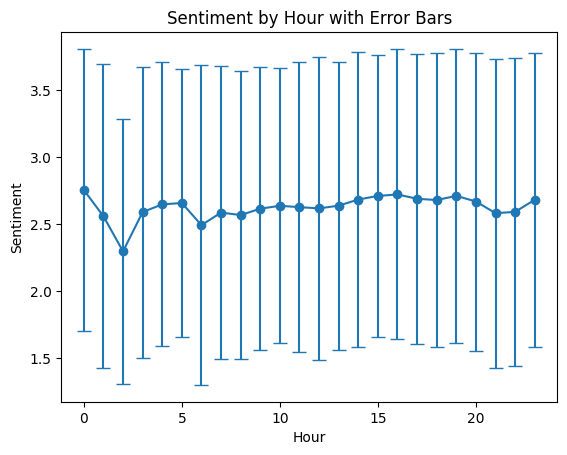

In [ ]:

tweet_df['hour'] = tweet_df['CreatedAt'].dt.hour

# Calculate mean and standard deviation of sentiment for each hour
hourly_mean = tweet_df.groupby('hour')['Sentiment'].mean()
hourly_std = tweet_df.groupby('hour')['Sentiment'].std()

# Create the line plot with error bars
plt.errorbar(hourly_mean.index, hourly_mean, yerr=hourly_std, fmt='-o', capsize=5)
plt.xlabel('Hour')
plt.ylabel('Sentiment')
plt.title('Sentiment by Hour with Error Bars')
plt.show()